# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [24]:
data_train = pd.read_csv('Google_Stock_Price_Train.csv')
data_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [25]:
# Only Numpy arrays can be the input for neural networks in KERAS
# .values() returns the Numpy Array.
train_set = data_train.iloc[:, 1:2].values  # Take the "Open" column

### Feature Scaling

In [26]:
# recommended to use Normalization for feature scaling for RNNs especially when there are sigmoid functions in output layer.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))  # Desired range of transformed data. -> (min,max)
train_set_scaled = sc.fit_transform(train_set)


### Creating a data structure with 60 timesteps and 1 output

**"Timesteps"** means how many values exist in a sequence. For example in [4, 7, 8, 4] there are 4 timesteps. features: how many dimensions are used to represent a data in one time step.<br>
For this Instance: <br>
60 timesteps means that at each timestamp,t the RNN will look at 60 stock prices before the timestamp, t. Stock prices within 60 days (3 months) before timestamp, t is considered for capturing the trend during these 60 stock prices and predict an output (stock price at t+1).

In [27]:
X_train = [] # lists , not NumPy array
y_train = [] # lists , not NumPy array
for i in range(60, 1258): # starting from 60 to 1258 (rows in dataframe)
    X_train.append(train_set_scaled[i-60:i, 0]) # previous 60 stock prices/rows selected of column 0 (prices frm t-60 to t-1)
    y_train.append(train_set_scaled[i, 0]) # actual stock price at t+1 (1 ta row) -> the model will try to predict this
X_train, y_train = np.array(X_train), np.array(y_train) # convert to NumPy arrays from lists

print(X_train.shape)
print(y_train.shape)

(1198, 60)
(1198,)


### Reshaping

In [28]:
# to add an extra dimension into the Numpy array we use the np.reshape() method
reshaped_X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# x_train.shape[0] => number of rows of x_train
# x_train.shape[1] => number of columns of x_train
reshaped_X_train.shape

(1198, 60, 1)



> We are reshaping the NumPy array **X_train** to make it compatible with the expected input shape of the RNN layers in Keras.<br>
**RNN layers in Keras expect input data in a 3D format**: (**batch_size**, **timesteps**, **input_dim**).


1.   <u>**batch_size:**</u> The number of samples in each batch.
2. <u>**timesteps:**</u> The number of time steps in each sample (in this case, 60, representing the past 60 stock prices).
3.   <u>**input_dim:**</u> The number of features at each time step (in this case, 1, representing the opening stock price).

Initially, **X_train** is a 2D array (number of samples, timesteps). By reshaping it, you're adding the third dimension (input_dim) with a value of 1, making it suitable for the RNN layers.

[Look for the input shape of LSTM Layers here <-](https://keras.io/2.16/api/layers/recurrent_layers/lstm/)

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [30]:
regressor = Sequential() #the RNN is called reggressor since we're predicting continuous values (regression)


### Adding the first LSTM layer and some Dropout regularisation

In [31]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (reshaped_X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) # Drop 20% of the neurons in the layer

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Regarding Dropout Regularization
It means making some neurons inactive.It also refers to dropping out units (both hidden and visible) in a neural network.<br>
In every training step, a neuron has probability, p of being active.<br>
This **p** is called **Dropout Rate**. <br>
For Example:


> Let,<br>
<u>DropOut Rate</u>, p = 0.25<br>
During training, we may randomly skip a few (one-fourth) neurons.<br>
But during test, we want each of them to be present.<br>
So, we calculate <u>keep probability:</u>
 K.P = 1 - 0.25 = 0.75 <br>
Since we have all the neurons active now, we need to multiply each inputs with the keep probability.<br>

For instance,


> <u>Inputs to neurons during training:</u> w1.5 + w2.6 + w3.3 (1 neuron inactive out of 4)<br>
<u>Inputs to neurons during testing:</u> w1.7 + w2.2 + w3.5+ w4.6 (All neurons active)<br>

Multiplying 0.25 with the inputs will give us a scaled version of the inputs which is similar to the training inputs.

** **Keras** implementation **divides the inputs with Keep Probability** during **training time** instead of **multiplying** during **test** . (Same Thing)   

[YouTube Video Explaining DropOut Rate](https://www.youtube.com/watch?v=kry2JghtMSY)





### Adding a second LSTM layer and some Dropout regularisation

In [32]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [33]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [34]:
regressor.add(LSTM(units = 50)) # last LSTM layer, so "return_sequences = False"
regressor.add(Dropout(0.2))

### Adding the output layer

In [35]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [36]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') # Binary cross-entropy use hbe na karon amra classification kortesi na.
# MSE loss function is used because we're predicting continuous value


### Fitting the RNN to the Training set

<u>**Batch Size:**</u> During training, the model updates its weights based on the error calculated from a batch of 32 such sequences. It **processes 32 sequences of 60 time steps each** before updating the weights. This is done to optimize the training process and make it more efficient. Essentially, **the model looks at 32 different "windows" of 60 days of stock prices simultaneously**, calculates the prediction error for each, and then adjusts the model's weights based on the average error across these 32 windows.

In [37]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - loss: 0.0983
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0071
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0056
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - loss: 0.0046
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0053
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 0.0045
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 0.0047
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.0052
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.0047
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0040
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.0040
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0045
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0039
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0042
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5

## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017 (full year)

In [38]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')  # stock price of 20 days in January 2017
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price.shape

(20, 1)

### Getting the predicted stock price of 2017



> We need the prices of previous 60 days to predict the next day price. Hence, to predict price for January 1st 2017, we need prices
from December 2016. That's why we need both the training and test dataset merged together.


In [39]:
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [40]:
dataset_total = pd.concat((data_train['Open'], dataset_test['Open']), axis = 0) # vertical concatenation; for axis=1 -> horizontal concatenation.
print(dataset_total.shape)
dataset_total.head()

(1278,)


,Open
0,325.25
1,331.27
2,329.83
3,328.34
4,322.04


In [41]:

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values # setting the limits to take the range of values (80 values)from "dataset_total"
inputs = inputs.reshape(-1,1) # reshapes the NumPy array inputs to have a single column.
inputs = sc.transform(inputs) # feature scaling (model trained on scaled values)
# Creating a data structure with 60 timesteps
x_test = [] # lists , not NumPy array
for i in range(60, 80): # starting from 60 to 80 (rows in dataframe)
    x_test.append(inputs[i-60:i, 0])  # previous 60 stock prices/rows selected of column 0 (prices frm t-60 to t-1)
x_test = np.array(x_test) # convert to NumPy arrays from lists
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) # reshaping for rnn input format
predicted_stock_price = regressor.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # inverse scaling to get original value

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


<u>**Setting the lower Limit:**</u><br>
len(dataset_total) = 20 + 1258 = 1278 (Last Day of 2017)<br>
len(dataset_total) - len(dataset_test) = 1278 - 20 = 1258 (First Day of 2017)<br>
1258 - 60 = Price of stock of the day 60 day before Jan 1st, 2017
<br>

<u>**Feature Scaling:**</u><br>
The scaler expects a 2D array as input. By reshaping the array to (-1, 1), we ensure that the input data is in the correct format for the scaler to process. The "-1" in the reshape function automatically calculates the number of rows based on the length of the original array and the specified number of columns (which is 1 in this case).
This step is crucial for consistency and compatibility with the scaling operation.




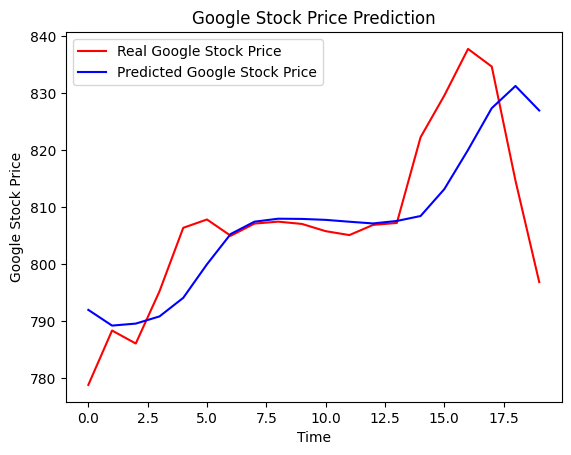

In [42]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()